In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import plotting


import auxil_ML as aux

In [2]:
plotting.setup_figure_pars()

0

In [109]:
derivation = 'Dima'
if derivation == 'Aakash':
    cat_fn = '../ML_3FGL_paper_extra/data/python files/catas/3fgl_multi_cata_newfeats.csv'
else:
    #cat_fn = 'data/3FGL_prob_catalog_3class.csv'
    cat_fn = 'data/3FGL_prob_catalog_3class_newfeats.csv'
cat_df3 = pd.read_csv(cat_fn, index_col=0)

folder = '../ML_3FGL_paper/SOM'
cat_fn = '%s/3FGL_prob_catalog.csv' % folder
cat_df2 = pd.read_csv(cat_fn, index_col=0)

In [110]:
cat_df2.columns

Index(['GLON', 'GLAT', 'ln(Energy_Flux100)', 'ln(Unc_Energy_Flux100)',
       'ln(Signif_Curve)', 'ln(Variability_Index)', '500MeV_Index', 'HR12',
       'HR23', 'HR34', 'HR45', 'Category_3FGL', 'CLASS_3FGL', 'Pivot_Energy',
       'Spectrum_Type', 'ASSOC1', 'Flags', 'AGN_BDT', 'AGN_BDT_STD', 'PSR_BDT',
       'PSR_BDT_STD', 'AGN_NN', 'AGN_NN_STD', 'PSR_NN', 'PSR_NN_STD', 'AGN_RF',
       'AGN_RF_STD', 'PSR_RF', 'PSR_RF_STD', 'AGN_LR', 'AGN_LR_STD', 'PSR_LR',
       'PSR_LR_STD', 'AGN_BDT_O', 'AGN_BDT_STD_O', 'PSR_BDT_O',
       'PSR_BDT_STD_O', 'AGN_NN_O', 'AGN_NN_STD_O', 'PSR_NN_O', 'PSR_NN_STD_O',
       'AGN_RF_O', 'AGN_RF_STD_O', 'PSR_RF_O', 'PSR_RF_STD_O', 'AGN_LR_O',
       'AGN_LR_STD_O', 'PSR_LR_O', 'PSR_LR_STD_O', 'Category_Prob'],
      dtype='object')

In [111]:
cat = '3FGL'
cls = 'OTHER'
nclass = 3
algs = ['RF', 'BDT', 'NN', 'LR']
#algs = ['RF', 'BDT', 'NN']
#algs = ['RF', 'BDT', 'LR']
alg0 = 'BDT'
alg0_ind = algs.index(alg0)
classes = ['AGN', 'PSR', 'OTHER'][:nclass]
add_errors = 0
save_plots = 1

if nclass == 2:
    cat_df = cat_df2
elif nclass == 3:
    cat_df = cat_df3
    if 'Category_Prob' not in cat_df.columns:
        print(classes)
        res = aux.get_prob_class(cat_df, algs, classes)
        cat_df = cat_df.merge(res, left_index=True, right_index=True)

nbins = 20
bins = np.linspace(0., 1., nbins + 1)
centers = (bins[1:] + bins[:-1]) / 2
assoc_sources = np.array((cat_df['Category_%s' % cat] == cls), dtype=float)

hsts = np.zeros((len(algs), len(centers)))
hsts_error = np.zeros((len(algs), len(centers)))
hsts_assoc = np.zeros((len(algs), len(centers)))

classif_sources = np.array((cat_df['Category_Prob'] == cls), dtype=float)
hsts_classif = np.zeros((len(algs), len(centers)))

In [117]:
#cat_df.columns
#list(cat_df['Category_Prob'])
nsrc = 0
for st in ['AGN', 'PSR', 'MIXED']:
    nsrc += np.sum(cat_df['Category_Prob'] == st)
print(nsrc)
print(np.sum(cat_df['Category_Prob'] == 'OTHER'))
print(np.sum(cat_df['Category_%s' % cat] == 'OTHER'))

2898
123
108


In [113]:
unas_mask = (cat_df['Category_%s' % cat] == 'UNAS')
if nclass == 2 and False:
    unas_mask |= (cat_df['Category_%s' % cat] == 'OTHER')
unas_mask = np.array(unas_mask, dtype=float)
assoc_mask = 1. - unas_mask

In [114]:
for i, alg in enumerate(algs):
    label = '%s_%s' % (cls, alg)
    hsts[i] = np.histogram(cat_df[label], bins=bins, weights=cat_df[label] * assoc_mask)[0]
    if add_errors:
        hsts_error[i] = np.histogram(cat_df[label], bins=bins, weights=cat_df[label + '_STD']**2 * assoc_mask)[0]
        hsts_error[i] = np.sqrt(hsts_error[i])
    hsts_assoc[i] = np.histogram(cat_df[label], bins=bins, weights=assoc_sources)[0]
    hsts_classif[i] = np.histogram(cat_df[label], bins=bins, weights=classif_sources)[0]

plots/3class/3FGL_3classes_RF_OTHER_Dima.pdf
plots/3class/3FGL_3classes_BDT_OTHER_Dima.pdf
plots/3class/3FGL_3classes_NN_OTHER_Dima.pdf
plots/3class/3FGL_3classes_LR_OTHER_Dima.pdf


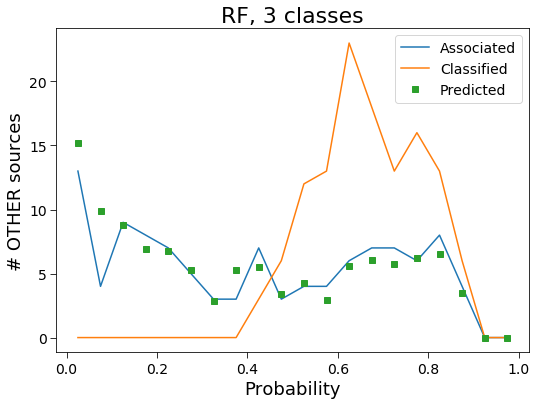

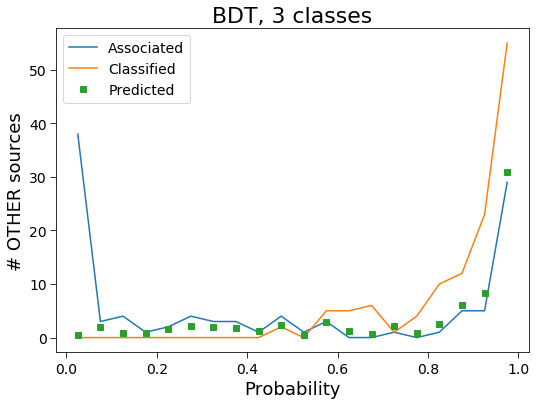

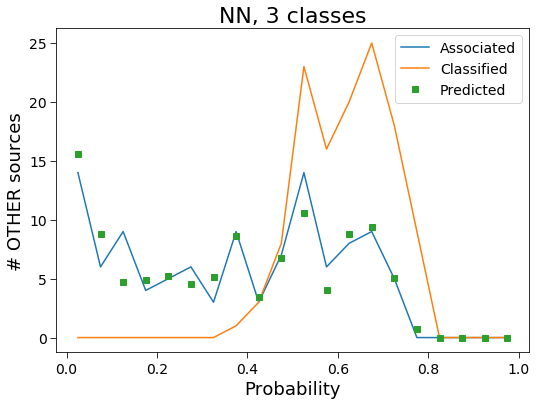

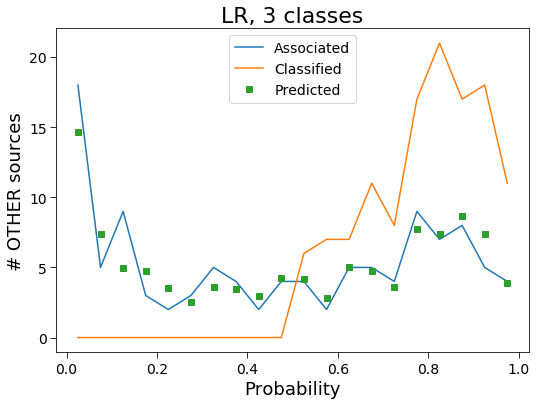

In [115]:
for i, alg in enumerate(algs):
    pyplot.figure()
    pyplot.plot(centers, hsts_assoc[i], label='Associated')
    if nclass == 2 or True:
        pyplot.plot(centers, hsts_classif[i], label='Classified')
    if add_errors:
        pyplot.errorbar(centers, hsts[i], hsts_error[i], ls='', marker='s', label='Predicted')
    else:
        pyplot.plot(centers, hsts[i], ls='', marker='s', label='Predicted')
    pyplot.xlabel('Probability')
    if cls == 'OTHER':
        pyplot.ylabel('# OTHER sources')
    else:
        pyplot.ylabel('# %s' % cls)
    data = np.sum(hsts_assoc[i])
    model = np.sum(hsts[i])
    error = np.sqrt(np.sum(hsts_error[i]))
    if add_errors:
        print('%s (data - model) / error = %.2f' % (alg, (data - model) / error))
    pyplot.title('%s, %i classes' % (algs[i], nclass))
    pyplot.legend()
    if save_plots:
        fn = 'plots/3class/%s_%iclasses_%s_%s.pdf' % (cat, nclass, alg, cls)
        if nclass == 3:
            fn = fn.replace('.pdf', '_%s.pdf' % derivation)
        print(fn)
        pyplot.savefig(fn)

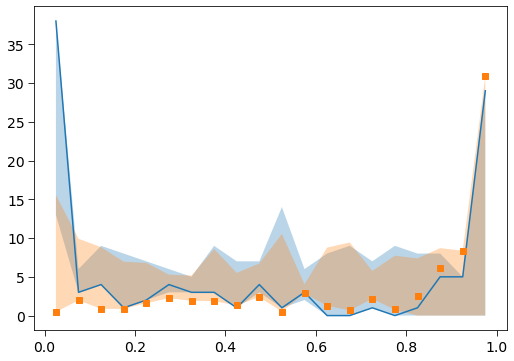

In [116]:
pyplot.figure()
pyplot.plot(centers, hsts_assoc[alg0_ind])
pyplot.fill_between(centers, np.min(hsts_assoc, axis=0), np.max(hsts_assoc, axis=0), alpha=0.3)
pyplot.errorbar(centers, hsts[alg0_ind], hsts_error[alg0_ind], ls='', marker='s')
pyplot.fill_between(centers, np.min(hsts, axis=0), np.max(hsts, axis=0), alpha=0.3)
